In [1]:
import pandas as pd
import numpy as np

import torch
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, BertModel, BertForSequenceClassification

/home/user/miniconda3/envs/velotix-ex/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('../data/amazon_reviews_reviewText_ratings.csv')
mini_df = df.sample(frac=0.5, random_state=42)
mini_df

,rating,reviewText
359522,5,"Love xylitol, a good substitute for white suga..."
374914,5,Perfect fit and quite affordable\n\nt
325093,3,Not much of a taste to them
227287,5,Love it and it really works!!!
46355,5,Sturdy. Better than what I expected for the p...
...,...,...
34582,5,"Excellent product, As described and delivered ..."
138296,5,Finally a trail mix that make you feel like yo...
304877,4,Pros:Good water conditioner. Cons: Misleading...
445555,5,This is great! I have some Trumpet vine roots ...


In [3]:
# Set up the GPU.
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
mini_df.head()

,rating,reviewText
359522,5,"Love xylitol, a good substitute for white suga..."
374914,5,Perfect fit and quite affordable\n\nt
325093,3,Not much of a taste to them
227287,5,Love it and it really works!!!
46355,5,Sturdy. Better than what I expected for the p...


In [5]:
train_dataset, test_dataset = train_test_split(mini_df, test_size=0.2, random_state=1)
test_dataset = test_dataset.reset_index(drop=True)

In [6]:
%%capture
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels = len(mini_df['rating'].unique()), # Number of unique labels for our multi-class classification problem.
    output_attentions = False,
    output_hidden_states = False,
)
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:

class ReviewsDataset(Dataset):
    def __init__(self, df, max_length=512):
        self.df = df
        self.tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
        self.max_length = max_length 
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        # input=review, label=stars
        review = self.df.loc[idx, 'reviewText']
        # labels are 0-indexed
        label = int(self.df.loc[idx, 'rating']) - 1
        
        encoded = self.tokenizer(
            review,                      # review to encode
            add_special_tokens=True,
            max_length=self.max_length,  # Truncate all segments to max_length
            padding='max_length',        # pad all reviews with the [PAD] token to the max_length
            return_attention_mask=True,  # Construct attention masks.
            truncation=True
        )
        
        input_ids = encoded['input_ids']
        attn_mask = encoded['attention_mask']
        
        return {
            'input_ids': torch.tensor(input_ids),
            'attn_mask': torch.tensor(attn_mask), 
            'label': torch.tensor(label)
        }

In [8]:
train_dataset, test_dataset = train_test_split(mini_df, test_size=0.2, random_state=1)

In [9]:
MAX_LEN = 256
TEST_SIZE = 0.2
VAL_SIZE = 0.125
TRAIN_BATCH_SIZE = 32
TEST_BATCH_SIZE = 32

CHECKPOINT_FILE = 'checkpoint.dat'
CHECKPOINT_FOLDER = 'Checkpoint'
EPOCHS = 3
LEARNING_RATE = 2e-05
PROJECT_FOLDER = '../models/'
MODEL_FOLDER = 'Model_V4'
SAVE_EVERY = 100
NUM_WORKERS = 4

In [10]:

train_dataset, test_dataset = train_test_split(mini_df, test_size=TEST_SIZE, random_state=1)
train_dataset, val_dataset = train_test_split(train_dataset, test_size=VAL_SIZE, random_state=1)

train_dataset = train_dataset.reset_index(drop=True)
val_dataset = val_dataset.reset_index(drop=True)
test_dataset = test_dataset.reset_index(drop=True)

train_set = ReviewsDataset(train_dataset, MAX_LEN)
val_set = ReviewsDataset(val_dataset, MAX_LEN)
test_set = ReviewsDataset(test_dataset, MAX_LEN)

print("# of samples in train set: {}".format(len(train_set)))
print("# of samples in val set: {}".format(len(val_set)))
print("# of samples in test set: {}".format(len(test_set)))

# of samples in train set: 173559
# of samples in val set: 24795
# of samples in test set: 49589


In [11]:
train_params = {
                'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': NUM_WORKERS
                }
val_params = train_params

test_params = {
                'batch_size': TEST_BATCH_SIZE,
                'shuffle': False,
                'num_workers': NUM_WORKERS
              }

train_loader = DataLoader(train_set, **train_params)
val_loader = DataLoader(val_set, **val_params)
test_loader = DataLoader(test_set, **test_params)

In [12]:

# For weighted Cross Entropy Loss
# Penalize errors higher if they come from a class with lower frequency
rating_groups = mini_df.groupby('rating')
rating_distribution = []
for i in range(len(df['rating'].unique())):
    rating_distribution.append(len(rating_groups.groups[i+1])/len(mini_df))

rating_distribution = torch.tensor(rating_distribution, dtype=torch.float32)

# V3
weights = 1.0 / rating_distribution
weights = weights / weights.sum()

# V4
# weights = 1.0 - star_distribution

print('{:<20}: {}'.format('rating distribution', rating_distribution.tolist()))
print('{:<20}: {}'.format('Weights', weights.tolist()))

rating distribution : [0.06259100139141083, 0.04359469562768936, 0.07557382434606552, 0.1340429037809372, 0.6841976046562195]
Weights             : [0.26161667704582214, 0.37561559677124023, 0.21667355298995972, 0.12216125428676605, 0.02393292263150215]


In [13]:

# Define the optimizer
loss_function = torch.nn.CrossEntropyLoss(weight=weights.to(device), reduction='mean')
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

In [14]:

# Define the accuracy function
def calculate_accuracy(big_idx, targets):
    n_correct = (big_idx==targets).sum().item()
    return n_correct

In [15]:

# For validation
def validate(model, data_loader):
    model.eval()
    n_correct = 0 
    nb_test_steps = 0
    nb_test_examples = 0
    test_loss = 0
    y_pred = []
    y_true = []

    with torch.no_grad():
        for _, data in enumerate(data_loader, 0):
            input_ids = data['input_ids'].to(device)
            mask = data['attn_mask'].to(device)
            labels = data['label'].to(device)

            outputs = model(input_ids, mask)
            loss = loss_function(outputs[0], labels)
            test_loss += loss.item()

            # gets labels with highest probabilities and their corresponding indices
            big_val, big_idx = torch.max(outputs[0].data, dim=1)
            n_correct += calculate_accuracy(big_idx, labels)

            preds = (big_idx + 1).cpu().tolist()
            gold = (labels + 1).cpu().tolist()
            y_pred.extend(preds)
            y_true.extend(gold)

            nb_test_steps += 1
            nb_test_examples += labels.size(0)
            
    epoch_loss = test_loss/nb_test_steps
    epoch_accu = (n_correct*100)/nb_test_examples
    print(f"Validation Loss: {epoch_loss}")
    print(f"Validation Accuracy: {epoch_accu}\n")
    
    return y_true, y_pred, epoch_accu

In [16]:
# Training loop
def train(epoch):
    # number of batches run by model
    nb_tr_steps = 0
    # number of training examples run by model
    nb_tr_examples = 0
    # number of examples classified correctly by model
    n_correct = 0
    tr_loss = 0
    model.train()

    for batch, data in enumerate(train_loader):
        input_ids = data['input_ids'].to(device)
        mask = data['attn_mask'].to(device)
        labels = data['label'].to(device)

        outputs = model(input_ids, mask)
        loss = loss_function(outputs[0], labels)
        tr_loss += loss.item()

        # gets labels with highest probabilities and their corresponding indices
        big_val, big_idx = torch.max(outputs[0].data, dim=1)
        n_correct += calculate_accuracy(big_idx, labels)

        nb_tr_steps += 1
        nb_tr_examples+=labels.size(0)
        
        if batch % SAVE_EVERY == 0:
            loss_step = tr_loss/nb_tr_steps
            accu_step = (n_correct*100)/nb_tr_examples 
            print("Batch {} of epoch {} complete.".format(batch, epoch+1))
            print(f"Training Loss: {loss_step}   Training Accuracy: {accu_step}")

            if not os.path.exists(CHECKPOINT_FOLDER):
              os.makedirs(CHECKPOINT_FOLDER)

            # Since a single epoch could take well over hours, we regularly save the model even during evaluation of training accuracy.
            torch.save(model.state_dict(), os.path.join(PROJECT_FOLDER, CHECKPOINT_FOLDER, CHECKPOINT_FILE))
            print("Saving checkpoint at", os.path.join(PROJECT_FOLDER, CHECKPOINT_FOLDER, CHECKPOINT_FILE))

        optimizer.zero_grad()
        loss.backward()
        # When using GPU
        optimizer.step()

    print('\n*****\n')
    print(f'The Total Accuracy for Epoch {epoch+1}: {(n_correct*100)/nb_tr_examples}')
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Training Loss: {epoch_loss}")
    print(f"Training Accuracy: {epoch_accu}\n")

    # Evaluate model after training it on this epoch
    validate(model, val_loader)

    torch.save(model.state_dict(), os.path.join(PROJECT_FOLDER, CHECKPOINT_FOLDER, CHECKPOINT_FILE))
    model.save_pretrained(os.path.join(PROJECT_FOLDER, MODEL_FOLDER, str(epoch+1)))
    print("Saving checkpoint at ", os.path.join(PROJECT_FOLDER, CHECKPOINT_FOLDER, CHECKPOINT_FILE))
    print("Saving model at ", os.path.join(PROJECT_FOLDER, MODEL_FOLDER, str(epoch+1)), '\n\n================================================\n')

    return

In [17]:
import os

# # Training without weighted loss
for epoch in range(EPOCHS):
    train(epoch)

Batch 0 of epoch 1 complete.
Training Loss: 1.758922815322876   Training Accuracy: 3.125
Saving checkpoint at ../models/Checkpoint/checkpoint.dat
Batch 100 of epoch 1 complete.
Training Loss: 1.5972976259665914   Training Accuracy: 27.13490099009901
Saving checkpoint at ../models/Checkpoint/checkpoint.dat
Batch 200 of epoch 1 complete.
Training Loss: 1.4991124992939964   Training Accuracy: 39.28793532338308
Saving checkpoint at ../models/Checkpoint/checkpoint.dat
Batch 300 of epoch 1 complete.
Training Loss: 1.3940781952930843   Training Accuracy: 45.743355481727576
Saving checkpoint at ../models/Checkpoint/checkpoint.dat
Batch 400 of epoch 1 complete.
Training Loss: 1.3340044732105703   Training Accuracy: 49.454488778054866
Saving checkpoint at ../models/Checkpoint/checkpoint.dat
Batch 500 of epoch 1 complete.
Training Loss: 1.2927983557868623   Training Accuracy: 51.85254491017964
Saving checkpoint at ../models/Checkpoint/checkpoint.dat
Batch 600 of epoch 1 complete.
Training Loss: 1

In [24]:
import torch

# Assuming 'model' is your model instance
model_state_dict = model.state_dict()

# Specify the path where you want to save the model
save_path = '/home/user/IdeaProjects/velotix_ex/models/Model_V4/3/bert_4.pth'

# Save the model's state dictionary
torch.save(model_state_dict, save_path)

In [19]:
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [20]:
model_save_path = '/home/user/IdeaProjects/velotix_ex/models/Model_V3/3/md'
model.save_pretrained(model_save_path)

In [21]:
print(f'Running validation on model trained on 2 epochs')

y_true, y_pred, epoch_acc = validate(model, test_loader)

Running validation on model trained on 2 epochs
Validation Loss: 1.0446064068713496
Validation Accuracy: 71.55820847365344



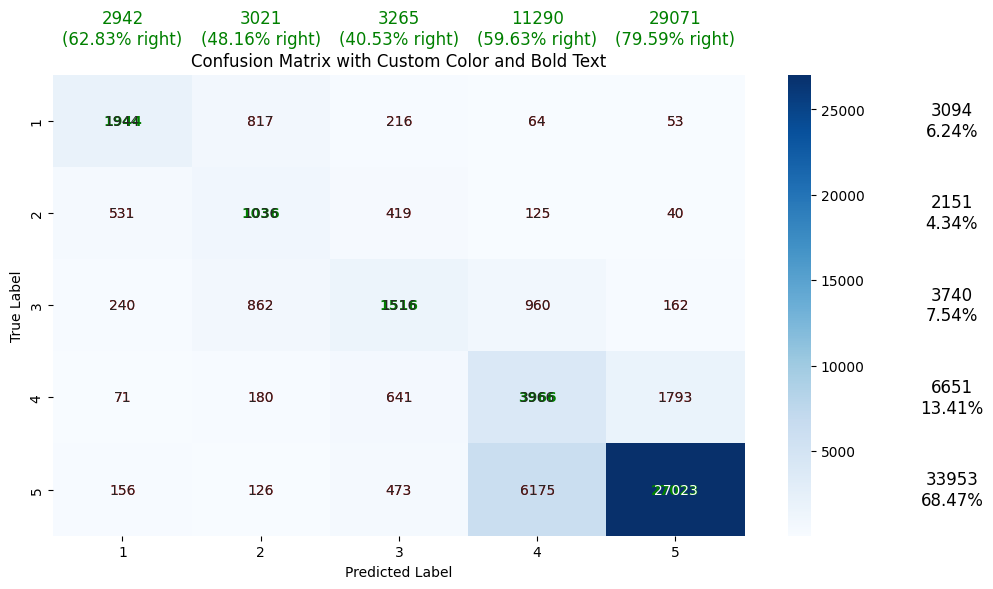

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

def conf_matrix(y_predicted, y_test):
    # Calculate the confusion matrix
    cm = confusion_matrix(y_test, y_predicted)
    classes = np.unique(y_test)

    # Correctly count occurrences using NumPy
    predicted_counts = [np.sum(y_predicted == i) for i in classes]
    accuracy_per_class = [100 * cm[i, i] / sum(cm[i]) for i in range(len(cm))]
    support = [np.sum(y_test == i) for i in classes]

    fig, ax = plt.subplots(figsize=(10, 6))

    # Plotting the confusion matrix with custom annotations
    for i in range(len(cm)):
        for j in range(len(cm[0])):
            color = 'green' if i == j else 'red'
            fontweight = 'bold' if i == j else 'normal'
            ax.text(j + 0.5, i + 0.5, cm[i, j],
                    ha="center", va="center", color=color, fontweight=fontweight)

    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', ax=ax)

    ax.set_title("Confusion Matrix with Custom Color and Bold Text")
    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("True Label")

    # Set the labels on x-axis and y-axis to start from 1
    ax.set_xticklabels([str(i) for i in range(1, len(classes) + 1)])
    ax.set_yticklabels([str(i) for i in range(1, len(classes) + 1)])

    for i, (count, accuracy) in enumerate(zip(predicted_counts, accuracy_per_class)):
        ax.text(i + 0.5, -0.5, f"{count}\n({accuracy:.2f}% right)", va='center', ha='center', fontsize=12, color='green')

    for i, count in enumerate(support):
        ax.text(len(cm)+1.5, i + 0.5, f"{count}\n{count/len(y_pred)*100:.2f}%", va='center', ha='center', fontsize=12)

    plt.tight_layout()
    plt.show()
    
conf_matrix(y_pred, y_true)

In [23]:
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,